In [1]:
from tokenizers import Tokenizer
from fourm.vq.vqvae import VQVAE, DiVAE
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2
from IPython.display import display, clear_output
import time
from skimage.metrics import structural_similarity as ssim

import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from fourm.data.modality_transforms import RGBTransform
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD, IMAGENET_DEFAULT_STD, IMAGENET_DEFAULT_MEAN
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/skalli/.local/lib/python3.10/site-packages/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available


In [14]:
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit',
    checkpoint_dec='/tmp/nvidiaxxxx/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit',
).to(device)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

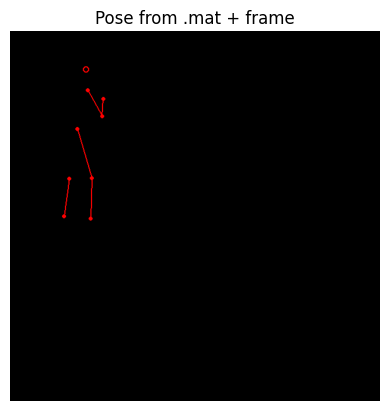

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image, ImageDraw

# Paths
video_id = "0001"
frames_dir = "penn_action_raw/Penn_Action/frames"
labels_dir = "penn_action_raw/Penn_Action/labels"
frame_path = os.path.join(frames_dir, video_id, "000001.jpg")
label_path = os.path.join(labels_dir, f"{video_id}.mat")

# Load image
frame = Image.open(frame_path).resize((640, 640))  # Ensure size match

# Load pose info
data = scipy.io.loadmat(label_path)
x = data['x'][1]
y = data['y'][1]
visibility = data['visibility'][1]

# Skeleton structure
skeleton_edges = [
    (1, 2), (1, 3), (2, 4), (3, 5), (4, 6),
    (7, 8), (7, 9), (8, 10), (9, 11), (10, 12)
]

# Draw skeleton
canvas = Image.new("RGBA", (640, 640), (0, 0, 0, 255))
draw = ImageDraw.Draw(canvas)

# Joints
for j in range(13):
    if visibility[j]:
        xj, yj = int(x[j]), int(y[j])
        if j == 0:
            draw.ellipse((xj-5, yj-5, xj+5, yj+5), outline="red", width=2)
        else:
            draw.ellipse((xj-3, yj-3, xj+3, yj+3), fill=(255, 0, 0, 255))

# Bones
for j1, j2 in skeleton_edges:
    if visibility[j1] and visibility[j2]:
        p1 = (int(x[j1]), int(y[j1]))
        p2 = (int(x[j2]), int(y[j2]))
        draw.line([p1, p2], fill="red", width=2)

# Head to hip center
if visibility[0] and visibility[7] and visibility[8]:
    head = (int(x[0]), int(y[0]))
    hip_center = tuple(np.mean([[x[7], y[7]], [x[8], y[8]]], axis=0).astype(int))
    draw.line([head, hip_center], fill="red", width=2)

# Show
plt.imshow(canvas)
plt.axis("off")
plt.title("Pose from .mat + frame")
plt.show()


torch.Size([1, 3, 640, 640])


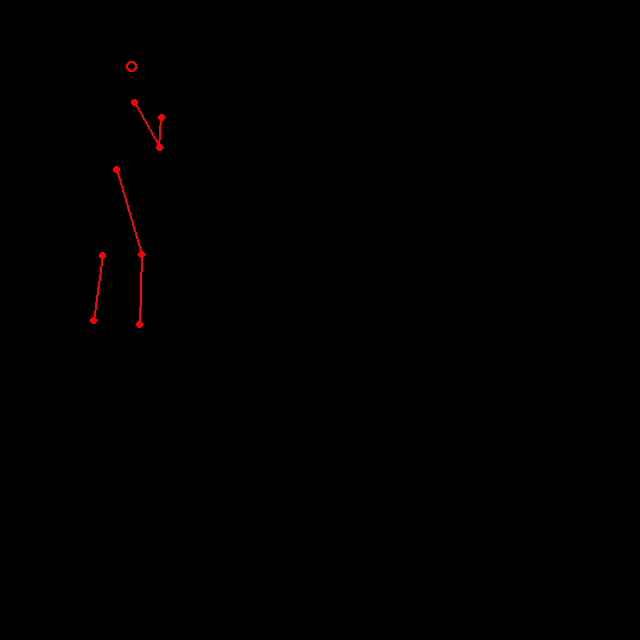

In [15]:
img_rgb = canvas.convert("RGB")  # drops the alpha channel
img_tensor = TF.to_tensor(img_rgb).to(device).unsqueeze(0) * 2 - 1
print(img_tensor.shape)
img_rgb

In [16]:
tokens, _ = image_tokenizer.encode(img_tensor)
print(tokens.shape)
print(tokens)

torch.Size([1, 40, 40])
tensor([[[42815, 16303, 15798,  ..., 16310, 16367, 34294],
         [17775, 20782, 16751,  ..., 17255, 32054,  7095],
         [27383,  3046,  2933,  ..., 15733, 13798, 19382],
         ...,
         [42743,  5543, 18230,  ..., 16751, 31534, 17335],
         [27503, 31029,   999,  ..., 15725, 14302, 21886],
         [33143,  9191, 35198,  ..., 17391, 19838, 22455]]], device='cuda:0',
       dtype=torch.int32)


In [17]:
reconst = image_tokenizer.decode(tokens).float().clamp(-1,1)

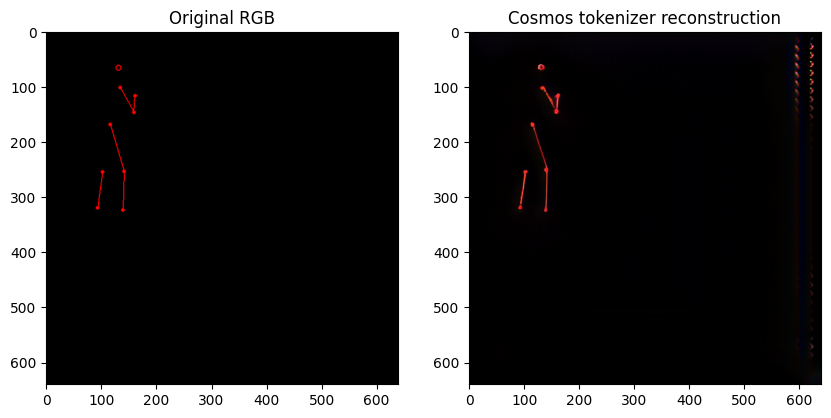

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(img_rgb)
ax[0].set_title('Original RGB')
ax[1].imshow(reconst[0].cpu().permute(1,2,0) / 2 + 0.5)
ax[1].set_title('Cosmos tokenizer reconstruction')
plt.show()